In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [13]:
def with_noise(x, variance):
    return np.random.normal(x, variance)

### Predict
\begin{equation}
    \hat{x_k} = F_k\hat{x_{k-1}} + B_ku_k
\end{equation}
\begin{equation}
    P_k = F_kP_{k-1}F_k^T + Q_k
\end{equation}
### Update
\begin{equation}
    \hat{x_k} := \hat{x_k} + K_k(z_k-H_k\hat{x_k})
\end{equation}
\begin{equation}
    P_k := P_k - K_kH_kP_k
\end{equation}
\begin{equation}
    K_k = P_kH_K^T(H_kP_kH_k^T + R_k)^{-1}
\end{equation}

Let's look at the model of a car moving with constant acceleration

\begin{gather}
    \mathbf{x_k} =
    \begin{bmatrix}
    x_k \\
    \dot{x_k}
    \end{bmatrix} = 
    \begin{bmatrix}
    1 & \Delta t \\
    0 & 1
    \end{bmatrix}
    \begin{bmatrix}
    x_{k_1} \\
    v_{k-1}
    \end{bmatrix} +
    \begin{bmatrix}
    \frac{1}{2} \Delta t^2 \\
    \Delta t
    \end{bmatrix}
    \begin{bmatrix}
    a
    \end{bmatrix}
\end{gather}



\begin{gather}
    P_k =
    \begin{bmatrix}
    \sigma_x & 0 \\
    0 & \sigma_v
    \end{bmatrix}
\end{gather}



We get P from the sensors, but we must also have some errors from let's say the friction with the athmosphere, wind gusts etc. We will put these in the Q matrix.

In [128]:
N = 300
# Generate the real data
def gen_data(n=N, time=1):
    data = []
    acceleration = 5
    x = 4000
    speed = 200
    
    x_real = []
    speed_real = []
    
    for _ in range(n):
        data.append([x, speed])
        
        x_real.append(x)
        speed_real.append(speed)
        
        if np.random.rand() < 0.3:
            speed *= -1
        
        speed = speed + time * acceleration
        x = x + speed * time
    return np.array(data), x_real, speed_real

In [169]:
# Setup the matrices
TIME = 1
POS_ESTIMATE_ERROR = 1000 # Position error from our estimate
SPEED_ESTIMATE_ERROR = 100 # Speed error from our estimate

POS_PROCESS_ERROR = 1000 # Position error from inexact model
SPEED_PROCESS_ERROR = 30 # Speed error from inexact model

POS_MEASUREMENT_ERROR = 1000 # Position error from our sensors
SPEED_MEASUREMENT_ERROR = 100 # Speed error from our sensors

F = np.array([[1, TIME], [0, 1]])
B = np.array([[TIME**2 / 2], [TIME]])
P = np.array([[POS_ESTIMATE_ERROR, 0], [0, SPEED_ESTIMATE_ERROR]])
Q = np.array([[POS_PROCESS_ERROR, 0], [0, SPEED_PROCESS_ERROR]])
R = np.array([[POS_MEASUREMENT_ERROR, 0], [0, SPEED_MEASUREMENT_ERROR]])
H = np.array([[1, 0], [0, 1]])


In [170]:
data, x_real, speed_real = gen_data()
data_with_noise = np.random.normal(data, [POS_MEASUREMENT_ERROR, SPEED_MEASUREMENT_ERROR])

x_estimates = []
vel_estimates = []


x = np.array([10, 10]) # Initial estimate of the state [position, speed]
u = np.array([10]) # Acceleration

# Run Kalman filter
for i in range(N):
    # Predict step
    x = np.add(F @ x, B @ u)
    P = F @ P @ F.transpose() + Q
    
    # Update step
    K = P @ H.transpose() @ np.linalg.inv((H @ P @ H.transpose() + R))
    x = x + K @ (data_with_noise[i] - H @ x)    
    P = P - K @ H @ P
    
    x_estimates.append(x[0])
    vel_estimates.append(x[1])

In [171]:
def plot_compare(real_data, est_data):
#     x = np.linspace(0, N, N)
    plt.figure(figsize=[20,10])
    plt.plot(real_data, color='tab:blue', label='Real')
    plt.plot(est_data, color='tab:red', label='Estimations')
    plt.legend()
    plt.show()
    

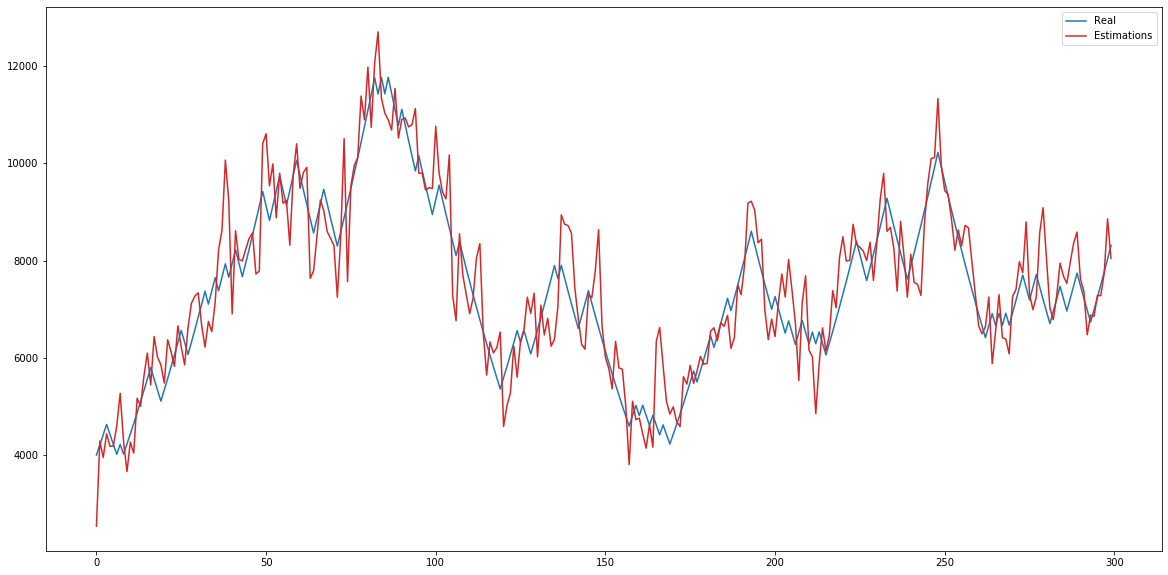

In [172]:
plot_compare(x_real, x_estimates)

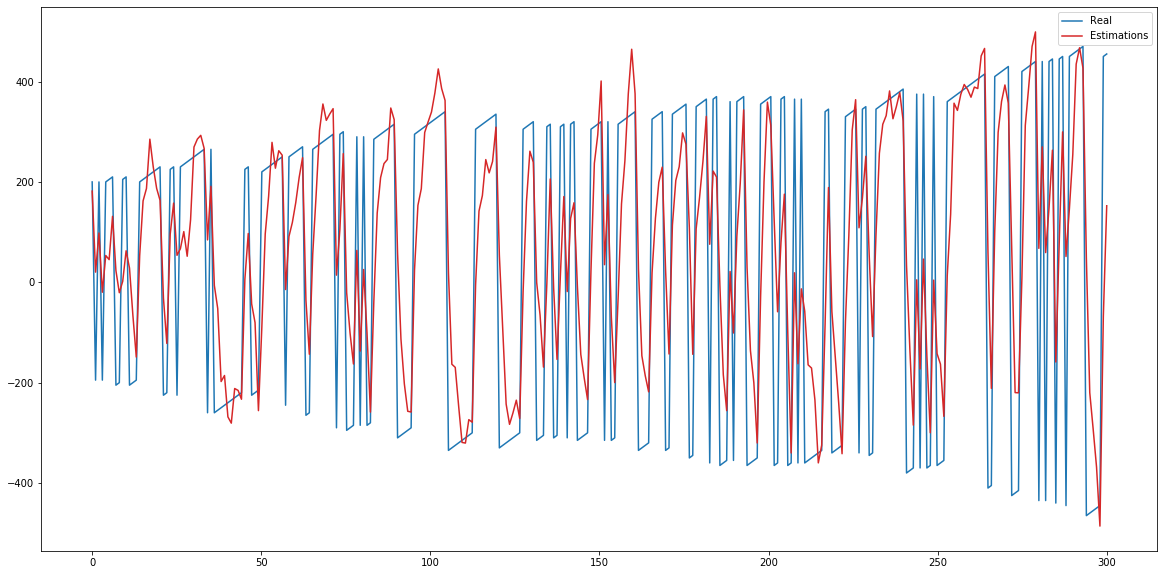

In [147]:
plot_compare(speed_real, vel_estimates)